In [13]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import math

np.random.seed(seed=999) #baka

%matplotlib inline

### 1. Исходные данные

In [14]:
sample1_k = 2
sample1_size = 150
sample1 = stats.chi2(sample1_k).rvs(sample1_size)
sample1_m = np.mean(sample1)
sample1_s2 = np.var(sample1, ddof=1) 

In [15]:
print(f"X: mean: {sample1_m:.3f} var: {np.var(sample1, ddof = 1):.3f} std: {np.std(sample1, ddof = 1):.3f}")

X: mean: 2.319 var: 4.991 std: 2.234


### 2. Визуальное представление выборки

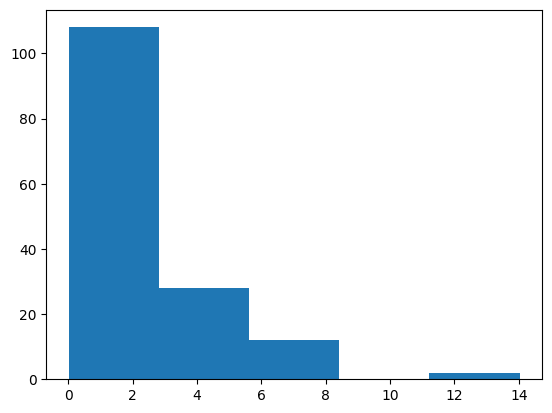

In [16]:
_ = plt.hist(sample1, bins=5)

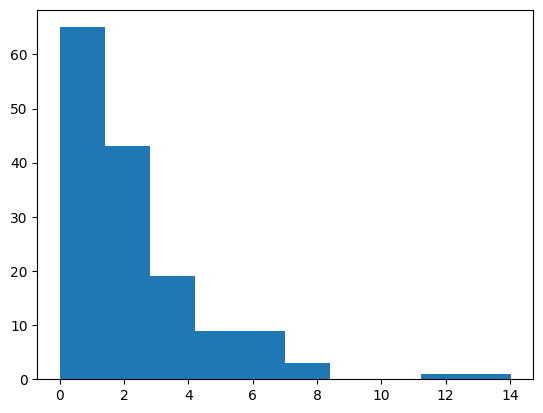

In [17]:
_ = plt.hist(sample1, bins=10)

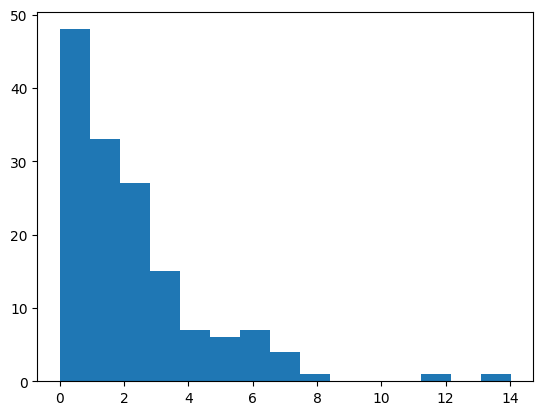

In [18]:
_ = plt.hist(sample1, bins=15)

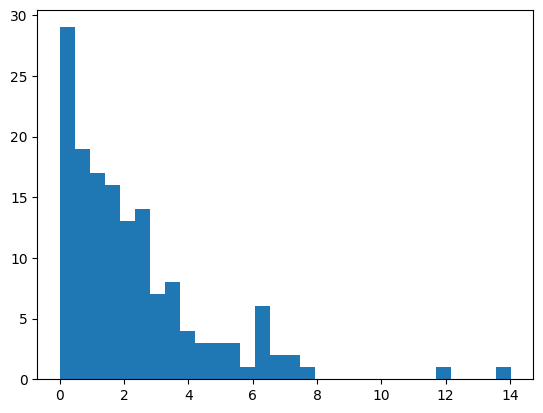

In [19]:
_ = plt.hist(sample1, bins=30)

### 3. Критерий хи-квадрат

In [20]:
def freqs_from_cdf(cdf, size, bin_num, begin, end):
    bin_size = abs(end - begin) / bin_num
    freqs = np.array([], dtype=float)
    for x in np.linspace(begin, end, bin_num):
        freqs = np.append(freqs, (cdf(x + bin_size) - cdf(x)) * size)
    return freqs

def merge_by_indices(hist, bins_to_merge):
    bins_to_merge_new = np.copy(bins_to_merge)
    new_hist = np.copy(hist)
    
    for indices in bins_to_merge_new:
        new_hist = np.insert(new_hist, indices[0], new_hist[indices[0]:indices[1]].sum())
        new_hist = np.delete(new_hist, range(indices[0] + 1, indices[1] + 1))
        bins_to_merge_new -= (indices[1] - indices[0]) - 1 
        
    return new_hist
    
def merge_lower_than_threshold(hist, threshold, max_merges=3):
    bins_to_merge = np.empty((0, 2), dtype=int)
    count = 0
    for i in range(hist.size):
        if hist[i] < threshold:
            count += 1
        if hist[i] >= threshold and count != 0 or count > max_merges:
            bins_to_merge = np.vstack((bins_to_merge, [i - count, i]))
            count = 0
    
    if count != 0:
        bins_to_merge = np.vstack((bins_to_merge, [hist.size - count, hist.size]))

    
    return merge_by_indices(hist, bins_to_merge), bins_to_merge

def chisquared(sample, exp_cdf, bin_num, ddof=0, merge_threshold=5, max_merges=math.inf):
    samp_hist, _ = np.histogram(sample, bins=bin_num)
    samp_hist, bins_to_merge = merge_lower_than_threshold(samp_hist, merge_threshold, max_merges)
    
    exp_hist = freqs_from_cdf(exp_cdf, sample.size, bin_num, sample.min(), sample.max())
    exp_hist = merge_by_indices(exp_hist, bins_to_merge)
    
    stat = 0
    for i in range(exp_hist.size):
        stat += (samp_hist[i] - exp_hist[i])**2 / exp_hist[i]
    pvalue = 1 - stats.chi2(bin_num - ddof - 1).cdf(stat)
    
    return stat, pvalue



#### а) Статистическая гипотеза: $H_0: X \sim N(m, σ)$

In [22]:
stat, pvalue = chisquared(sample1, stats.norm(np.mean(sample1), np.var(sample1, ddof = 1)).cdf, 5)
print(f"bins: 5 stat: {stat:.3f} pvalue: {pvalue}")

stat, pvalue = chisquared(sample1, stats.norm(np.mean(sample1), np.var(sample1, ddof = 1)).cdf, 10)
print(f"bins: 10 stat: {stat:.3f} pvalue: {pvalue}")

stat, pvalue = chisquared(sample1, stats.norm(np.mean(sample1), np.var(sample1, ddof = 1)).cdf, 15)
print(f"bins: 15 stat: {stat:.3f} pvalue: {pvalue}")

stat, pvalue = chisquared(sample1, stats.norm(np.mean(sample1), np.var(sample1, ddof = 1)).cdf, 30)
print(f"bins: 30 stat: {stat:.3f} pvalue: {pvalue}")

bins: 5 stat: 178.333 pvalue: 0.0
bins: 10 stat: 205.206 pvalue: 0.0
bins: 15 stat: 217.571 pvalue: 0.0
bins: 30 stat: 234.011 pvalue: 0.0


#### б) Статистическая гипотеза: $H_0: X \sim R(a, b)$

#### 